# Notebook 3 — Cross-Domain Integration & EDA

**Goal**  
Integrate ad impression data with feed-derived user profiles, then perform two-stage EDA:

1. **Pre-Merge EDA (Ads-Only):** understand structure, distributions, and correlations inside the ads domain.
2. **Post-Merge EDA (Merged Ads + Feeds Profiles):** examine cross-domain patterns related to CTR.

**Inputs (from previous notebooks)**  
- `ads_train_clean.parquet`, `ads_test_clean.parquet`  *(Notebook 1 outputs)*  
- `feeds_user_agg_train.parquet`, `feeds_user_agg_test.parquet`  *(Notebook 2 outputs)*

## 3.1 Load Cleaned Datasets

We load all four cleaned/aggregated datasets and perform quick structural checks:
- Confirm expected columns exist (`user_id` in ads; `u_userId` in feeds user profiles).
- Inspect shapes, dtypes, and small samples.

In [6]:
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

# === Load files ===
ads_tr = pd.read_parquet('ads_train_clean.parquet')
ads_te = pd.read_parquet('ads_test_clean.parquet')
fagg_tr = pd.read_parquet('feeds_user_agg_train.parquet')
fagg_te = pd.read_parquet('feeds_user_agg_test.parquet')

print("Loaded:")
print(" - ads_train_clean.parquet:", ads_tr.shape)
print(" - ads_test_clean.parquet :", ads_te.shape)
print(" - feeds_user_agg_train.parquet:", fagg_tr.shape)
print(" - feeds_user_agg_test.parquet :", fagg_te.shape)

# === Minimal schema checks ===
required_ads_keys = ['user_id']
required_fagg_keys = ['u_userId']

missing_ads = [c for c in required_ads_keys if c not in ads_tr.columns]
missing_fagg = [c for c in required_fagg_keys if c not in fagg_tr.columns]

print("\nKey columns present?")
print(" - ads_train contains user_id? ->", "OK" if not missing_ads else f"Missing: {missing_ads}")
print(" - feeds_user_agg_train contains u_userId? ->", "OK" if not missing_fagg else f"Missing: {missing_fagg}")

# === Quick peeks ===
print("\n[Preview] ads_train_clean (head):")
display(ads_tr.head(3))

print("\n[Preview] feeds_user_agg_train (head):")
display(fagg_tr.head(3))

print("\n[Preview] ads_test_clean (head):")
display(ads_te.head(2))

print("\n[Preview] feeds_user_agg_test (head):")
display(fagg_te.head(2))

Loaded:
 - ads_train_clean.parquet: (7675517, 52)
 - ads_test_clean.parquet : (976058, 51)
 - feeds_user_agg_train.parquet: (180123, 17)
 - feeds_user_agg_test.parquet : (51162, 17)

Key columns present?
 - ads_train contains user_id? -> OK
 - feeds_user_agg_train contains u_userId? -> OK

[Preview] ads_train_clean (head):


,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle,t_hour,t_wday,t_is_weekend,ad_click_list_v001_len,ad_click_list_v001_uniq,ad_click_list_v002_len,ad_click_list_v002_uniq,ad_click_list_v003_len,ad_click_list_v003_uniq,ad_close_list_v001_len,ad_close_list_v001_uniq,ad_close_list_v002_len,ad_close_list_v002_uniq,ad_close_list_v003_len,ad_close_list_v003_uniq,u_newsCatInterestsST_len,u_newsCatInterestsST_uniq
0,373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15,3,4,0,4,4,3,3,3,3,1,1,1,1,1,1,3,3
1,373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15,3,4,0,4,4,3,3,3,3,1,1,1,1,1,1,3,3
2,373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15,3,4,0,4,4,3,3,3,3,1,1,1,1,1,1,3,3



[Preview] feeds_user_agg_train (head):


,u_userId,f_rows,f_refresh_mean,f_refresh_sum,f_cat_uniq,f_entities_len_mean,f_up_mean,f_up_sum,f_dislike_mean,f_dislike_sum,f_avg_hour,f_peak_hour,f_browser_mode,f_browser_life,f_phone_price_median,f_hour_sin,f_hour_cos
0,100001,6,0.0,0,4,3.333333,6.0,36,5.333333,32,9.0,9,10,15.0,16.0,0.707107,-7.071068e-01
1,100002,3,0.0,0,2,5.000000,9.0,27,3.666667,11,18.0,11,13,15.0,11.0,-1.000000,-1.836970e-16
2,100003,6,2.0,12,3,4.666667,8.0,48,3.500000,21,17.0,17,13,17.0,16.0,-0.965926,-2.588190e-01



[Preview] ads_test_clean (head):


,log_id,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle,t_hour,t_wday,t_is_weekend,ad_click_list_v001_len,ad_click_list_v001_uniq,ad_click_list_v002_len,ad_click_list_v002_uniq,ad_click_list_v003_len,ad_click_list_v003_uniq,ad_close_list_v001_len,ad_close_list_v001_uniq,ad_close_list_v002_len,ad_close_list_v002_uniq,ad_close_list_v003_len,ad_close_list_v003_uniq,u_newsCatInterestsST_len,u_newsCatInterestsST_uniq
0,242295,100002,2,3,13,225,2,31,3,21,210,2177,4,14584,17683,5,1236,3,22,1,213,18,23,0.0,21791^33265,2020^1236,352,24107,1218,173,202206101201,86^15^86^112^191,0,15,12,4,0,2,2,2,2,1,1,1,1,1,1,1,1,5,4
1,242300,100002,2,3,13,225,2,31,3,21,210,2419,6,14584,17683,5,1236,3,13,1,213,18,23,0.0,21791^33265,2020^1236,352,24107,1218,173,202206101154,86^15^86^112^191,0,15,11,4,0,2,2,2,2,1,1,1,1,1,1,1,1,5,4



[Preview] feeds_user_agg_test (head):


,u_userId,f_rows,f_refresh_mean,f_refresh_sum,f_cat_uniq,f_entities_len_mean,f_up_mean,f_up_sum,f_dislike_mean,f_dislike_sum,f_avg_hour,f_peak_hour,f_browser_mode,f_browser_life,f_phone_price_median,f_hour_sin,f_hour_cos
0,100002,2,0.0,0,2,2.5,5.5,11,4.5,9,12.0,12,14,17.0,11.0,1.224647e-16,-1.000000e+00
1,100004,1,0.0,0,1,5.0,6.0,6,0.0,0,18.0,18,10,15.0,10.0,-1.000000e+00,-1.836970e-16


## 3.2 Pre-Merge EDA (Ads-Only)

We explore the ad impression dataset before merging:
1. **CTR (label) distribution**
2. **Numerical correlation heatmap**
3. **CTR by demographics and time**

Overall CTR (mean of label): 1.5522%


/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_90061/3948364987.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=ads_tr, palette='pastel')


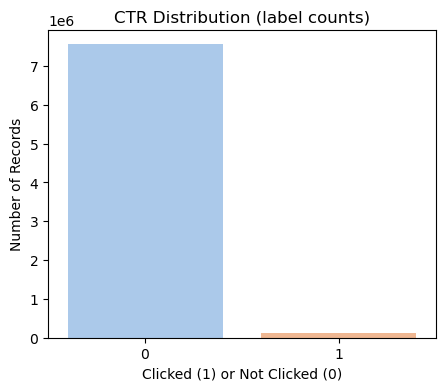

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

ctr_rate = ads_tr['label'].mean()
print(f"Overall CTR (mean of label): {ctr_rate:.4%}")

plt.figure(figsize=(5,4))
sns.countplot(x='label', data=ads_tr, palette='pastel')
plt.title("CTR Distribution (label counts)")
plt.xlabel("Clicked (1) or Not Clicked (0)")
plt.ylabel("Number of Records")
plt.show()

### 3.2.2 Correlation Heatmap (Numerical Features)

We examine linear correlations between numeric columns in the ad dataset.
This helps identify:
- Highly correlated or redundant columns (e.g., device or city fields)
- Weak correlation of numeric features with CTR (label)

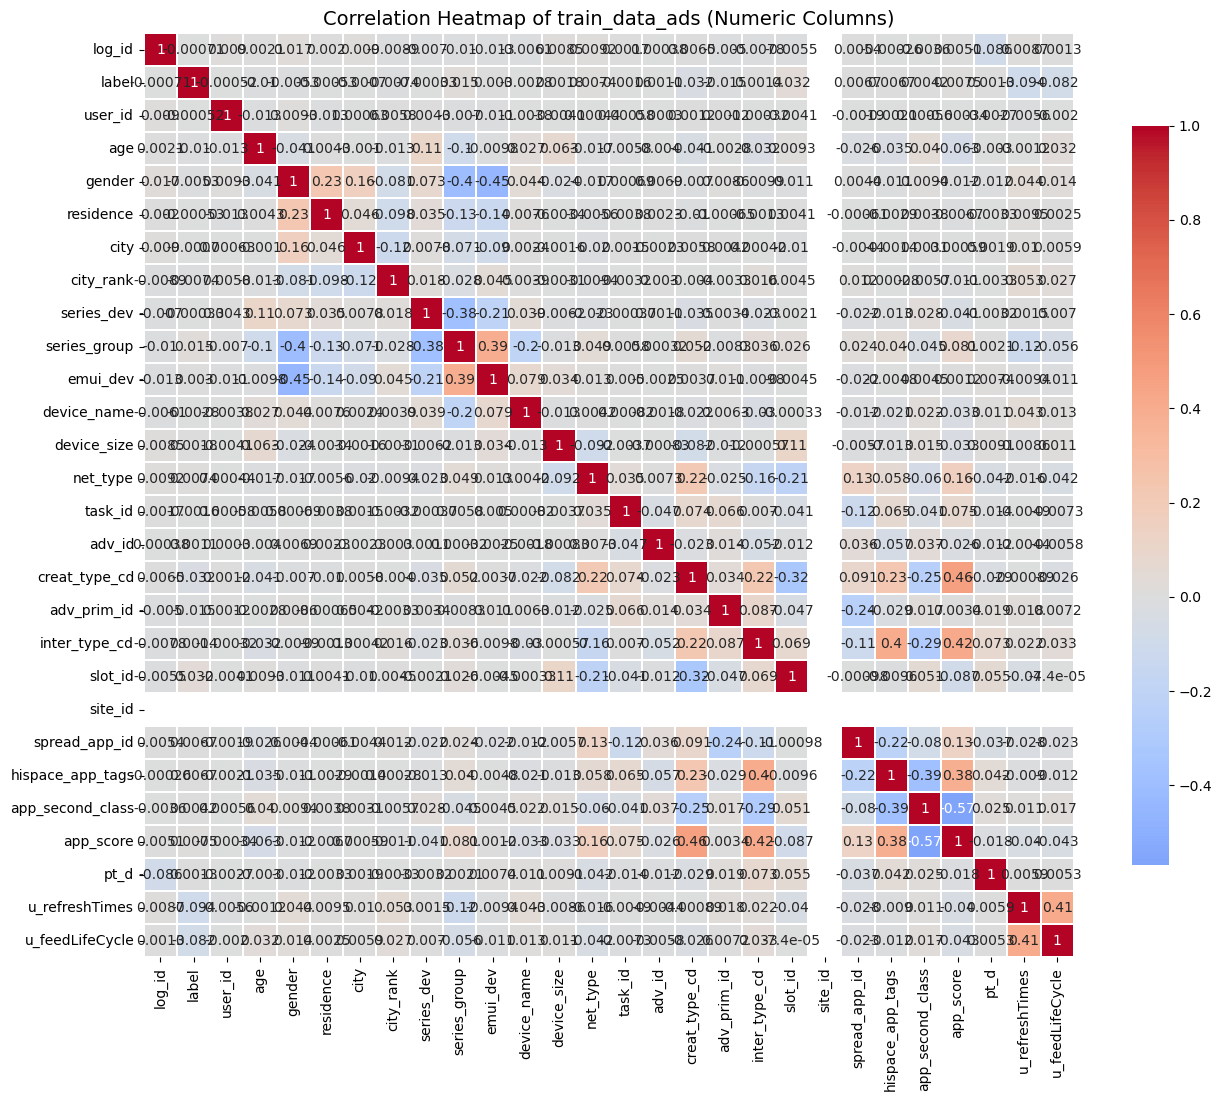


Top correlations with label:
label               1.000000
slot_id             0.032294
series_group        0.015186
app_score           0.007550
net_type            0.007367
hispace_app_tags    0.006740
spread_app_id       0.006717
app_second_class    0.004205
emui_dev            0.003037
device_size         0.001780
Name: label, dtype: float64

Lowest correlations with label:
task_id           -0.001648
device_name       -0.002834
gender            -0.005291
city_rank         -0.007359
age               -0.010021
adv_prim_id       -0.014903
creat_type_cd     -0.031604
u_feedLifeCycle   -0.082106
u_refreshTimes    -0.093926
site_id                 NaN
Name: label, dtype: float64


In [14]:
# Select numeric columns
num_cols = ads_tr.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation matrix
corr = ads_tr[num_cols].corr()

# Plot heatmap with annotations
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,         
    linewidths=0.3,     
    cbar_kws={"shrink": .8}  
)
plt.title("Correlation Heatmap of train_data_ads (Numeric Columns)", fontsize=14)
plt.show()

# Show correlation values with label
label_corr = corr['label'].sort_values(ascending=False)
print("\nTop correlations with label:")
print(label_corr.head(10))
print("\nLowest correlations with label:")
print(label_corr.tail(10))

### 3.2.3 CTR by Demographics and Time

We analyze how click-through rate (CTR) varies across key user demographics (age, gender)
and temporal features (hour of day, weekday).
This helps uncover behavioral patterns in user engagement.

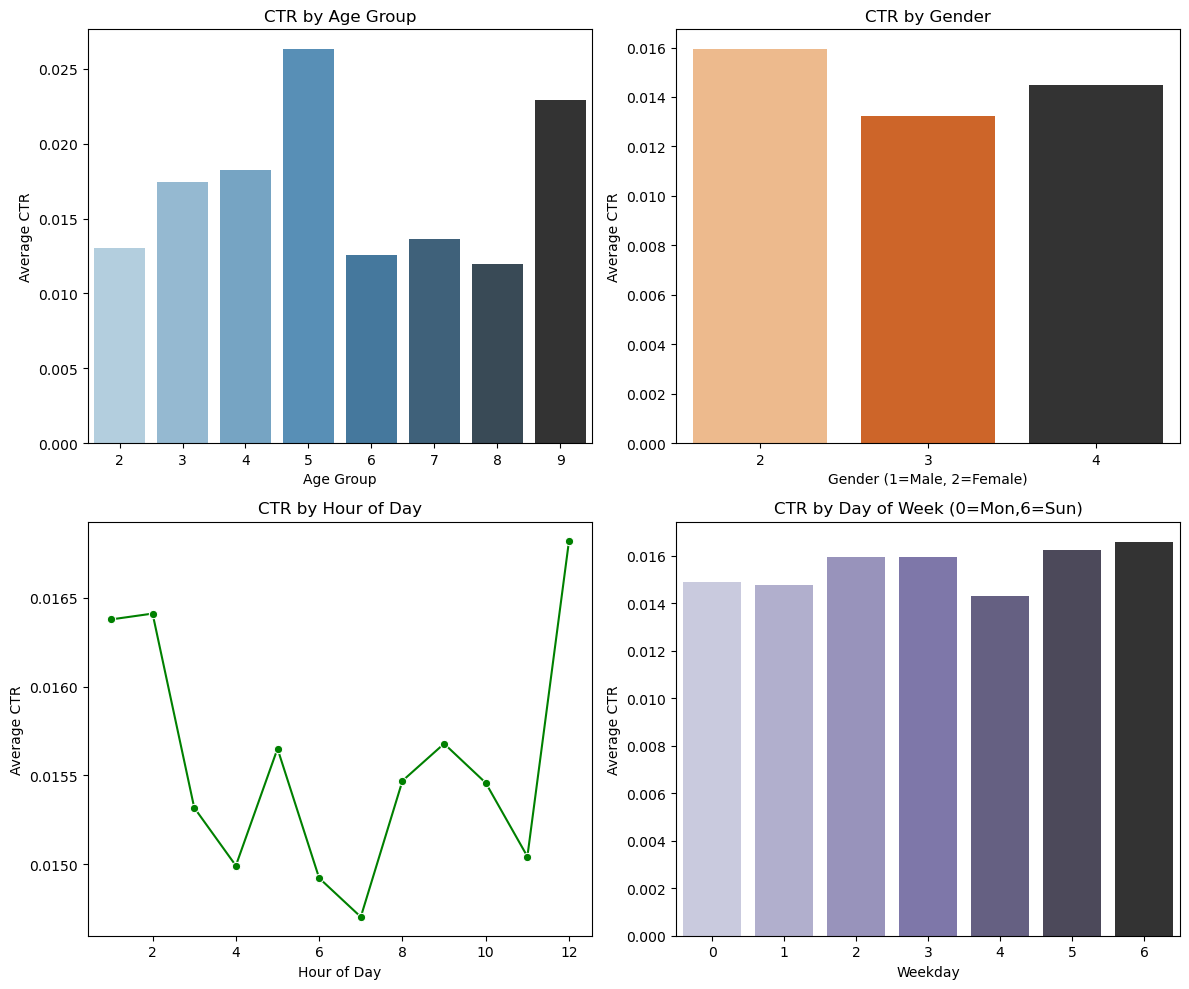

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average CTR by key demographic and temporal features
ctr_by_age = ads_tr.groupby("age")["label"].mean().reset_index()
ctr_by_gender = ads_tr.groupby("gender")["label"].mean().reset_index()
ctr_by_hour = ads_tr.groupby("t_hour")["label"].mean().reset_index()
ctr_by_wday = ads_tr.groupby("t_wday")["label"].mean().reset_index()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# CTR by age
sns.barplot(data=ctr_by_age, x="age", y="label", hue="age", ax=axes[0,0], palette="Blues_d", legend=False)
axes[0,0].set_title("CTR by Age Group")
axes[0,0].set_ylabel("Average CTR")
axes[0,0].set_xlabel("Age Group")

# CTR by gender
sns.barplot(data=ctr_by_gender, x="gender", y="label", hue="gender", ax=axes[0,1], palette="Oranges_d", legend=False)
axes[0,1].set_title("CTR by Gender")
axes[0,1].set_ylabel("Average CTR")
axes[0,1].set_xlabel("Gender (1=Male, 2=Female)")

# CTR by hour of day
sns.lineplot(data=ctr_by_hour, x="t_hour", y="label", ax=axes[1,0], marker="o", color="green")
axes[1,0].set_title("CTR by Hour of Day")
axes[1,0].set_ylabel("Average CTR")
axes[1,0].set_xlabel("Hour of Day")

# CTR by day of week
sns.barplot(data=ctr_by_wday, x="t_wday", y="label", hue="t_wday", ax=axes[1,1], palette="Purples_d", legend=False)
axes[1,1].set_title("CTR by Day of Week (0=Mon,6=Sun)")
axes[1,1].set_ylabel("Average CTR")
axes[1,1].set_xlabel("Weekday")

plt.tight_layout()
plt.show()

### 3.2.4 CTR by Device and Network Type

We analyze how CTR varies across device-related and network-related attributes.
This helps reveal whether higher-end devices or faster network connections
are associated with higher engagement levels.

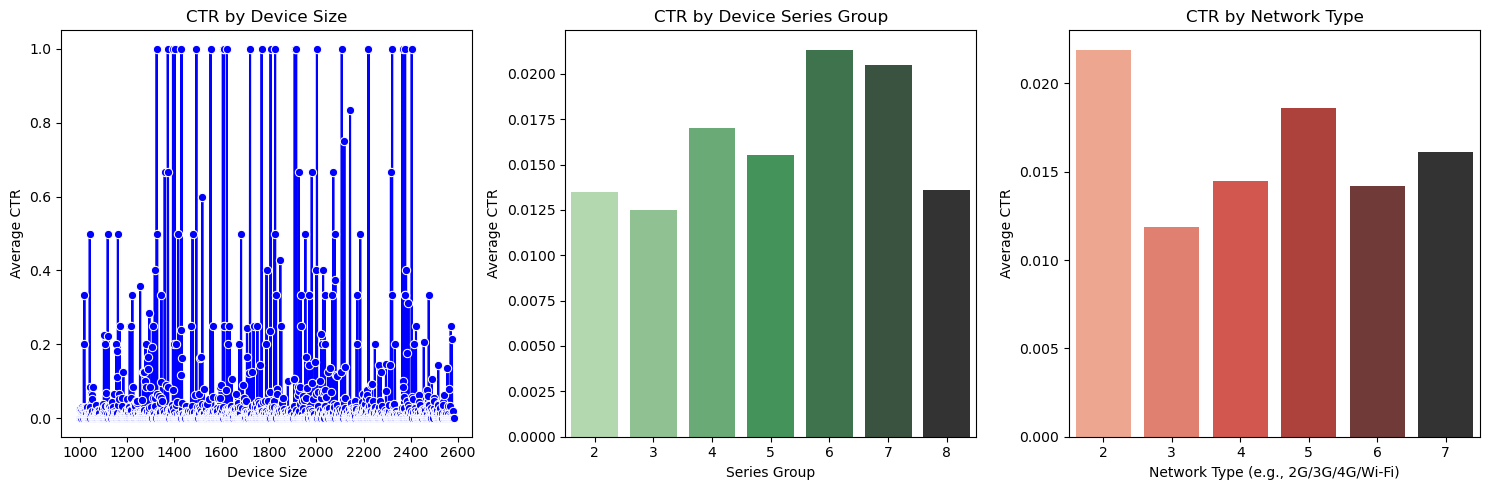

In [36]:
# Calculate average CTR by device and network features
ctr_by_device = ads_tr.groupby("device_size")["label"].mean().reset_index()
ctr_by_series = ads_tr.groupby("series_group")["label"].mean().reset_index()
ctr_by_net = ads_tr.groupby("net_type")["label"].mean().reset_index()

# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CTR by device size
sns.lineplot(data=ctr_by_device, x="device_size", y="label", ax=axes[0], marker="o", color="blue", legend=False)
axes[0].set_title("CTR by Device Size")
axes[0].set_xlabel("Device Size")
axes[0].set_ylabel("Average CTR")

# CTR by series group
sns.barplot(data=ctr_by_series, x="series_group", y="label", 
            hue="series_group", palette="Greens_d", legend=False, ax=axes[1]) 
axes[1].set_title("CTR by Device Series Group")
axes[1].set_xlabel("Series Group")
axes[1].set_ylabel("Average CTR")

# CTR by network type
sns.barplot(data=ctr_by_net, x="net_type", y="label", 
            hue="net_type", palette="Reds_d", legend=False, ax=axes[2])
axes[2].set_title("CTR by Network Type")
axes[2].set_xlabel("Network Type (e.g., 2G/3G/4G/Wi-Fi)")
axes[2].set_ylabel("Average CTR")

plt.tight_layout()
plt.show()

### 3.3 Merge Ads and Feeds User Profiles

We integrate ad impression records with user-level features aggregated from the feeds domain.
This step bridges the two data sources:
- `train_data_ads` (ad-level data, CTR label)
- `feeds_user_agg_train` (user-level data, behavior features)

Merging key:
- `user_id` in ads → `u_userId` in feeds

Expected output:
- Each ad impression record now contains user behavior summaries.
- Same with test data

In [60]:
# --- Merge train ---
train_merged = ads_tr.merge(
    fagg_tr,
    how="left",
    left_on="user_id",
    right_on="u_userId",
    suffixes=("", "_f")
)
if "u_userId" in train_merged.columns:
    train_merged = train_merged.drop(columns=["u_userId"])

print("Train merging complete!")
print("Train merged shape:", train_merged.shape)


# --- Merge test ---
test_merged = ads_te.merge(
    fagg_te,
    how="left",
    left_on="user_id",
    right_on="u_userId",
    suffixes=("", "_f")
)
if "u_userId" in test_merged.columns:
    test_merged = test_merged.drop(columns=["u_userId"])

print("Test merging complete!")
print("Test merged shape:", test_merged.shape)

Train merging complete!
Train merged shape: (7675517, 68)
Test merging complete!
Test merged shape: (976058, 67)


### 3.4 Post-Merge EDA — Understanding User-Behavior Features

After merging the ad-level and user-level datasets,  
we now explore whether the aggregated user features  
(e.g., average likes, average dislikes, browsing time)  
show any correlation with the click-through rate (CTR).

We focus on:
- `f_up_mean` and `f_dislike_mean` — engagement level  
- `f_avg_hour` — typical browsing hour  
- `f_phone_price_median` — proxy for device quality

/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_90061/1399633392.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_90061/1399633392.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_90061/1399633392.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_90061/1399633392.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

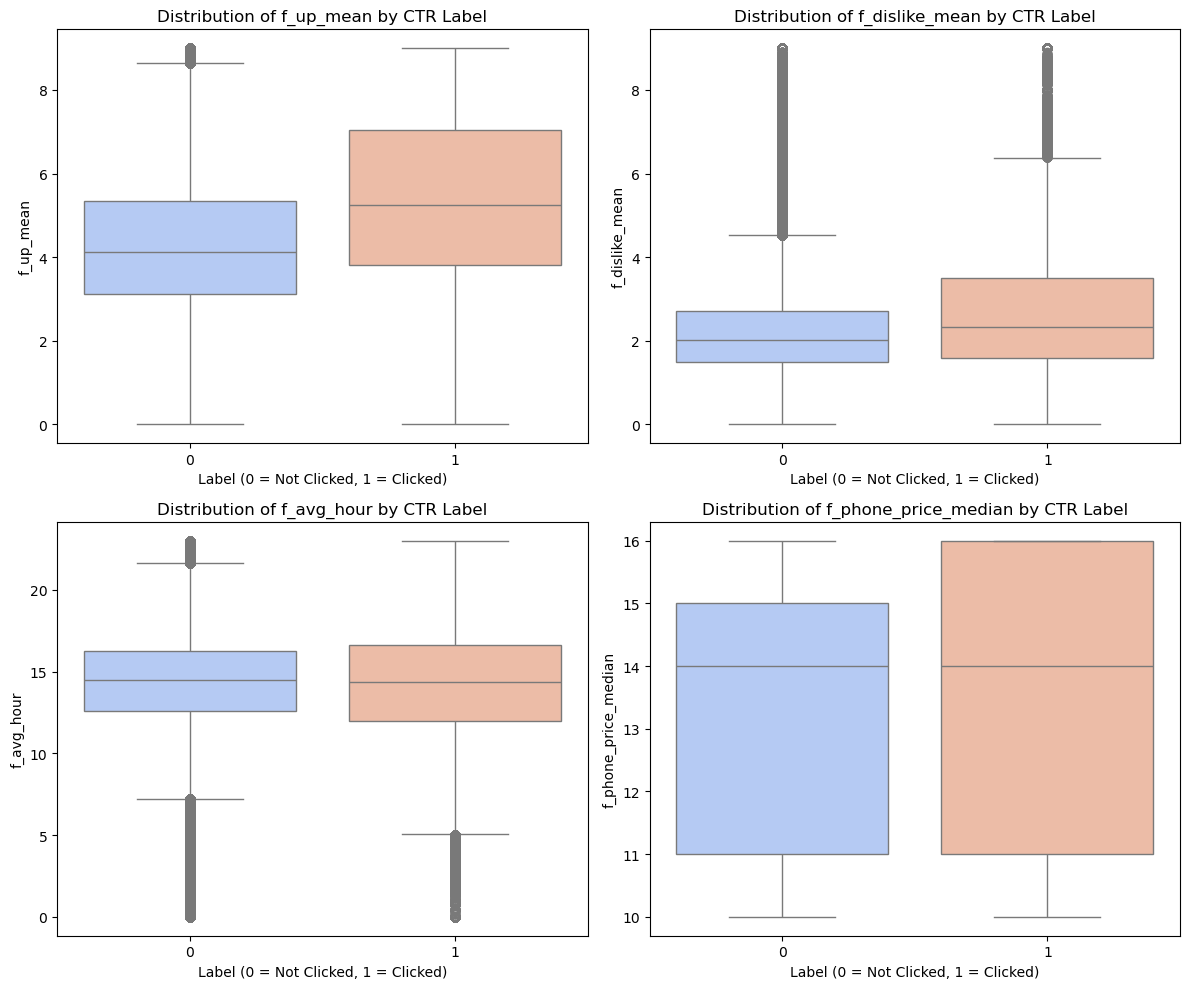

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select key merged features to inspect
features_to_check = ["f_up_mean", "f_dislike_mean", "f_avg_hour", "f_phone_price_median"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feat in enumerate(features_to_check):
    sns.boxplot(
        data=train_merged,
        x="label",
        y=feat,
        ax=axes[i],
        palette="coolwarm"
    )
    axes[i].set_title(f"Distribution of {feat} by CTR Label")
    axes[i].set_xlabel("Label (0 = Not Clicked, 1 = Clicked)")
    axes[i].set_ylabel(feat)

plt.tight_layout()
plt.show()

### 3.5 Correlation Heatmap — Understanding Overall Feature Relationships

After merging ad-level and user-level data,  
we visualize the correlation matrix to identify how  
user behavioral features interact with ad-level attributes  
and which features have the strongest relationships with the CTR (label).

We'll focus on:
- The strength of correlation between each user feature and `label`
- Any multicollinearity between user features
- Whether new features (feeds aggregates) introduce new signal

Top correlations with label:
 label                   1.000000
f_up_mean               0.082273
f_dislike_mean          0.056889
slot_id                 0.032294
f_hour_cos              0.029466
f_hour_sin              0.017608
series_group            0.015186
f_phone_price_median    0.013560
app_score               0.007550
net_type                0.007367
Name: label, dtype: float64

Lowest correlations with label:
 ad_click_list_v001_uniq     -0.070344
ad_click_list_v001_len      -0.070344
u_feedLifeCycle             -0.082106
f_cat_uniq                  -0.082369
f_browser_life              -0.086659
u_refreshTimes              -0.093926
f_refresh_mean              -0.094289
u_newsCatInterestsST_uniq   -0.113587
u_newsCatInterestsST_len    -0.137679
site_id                           NaN
Name: label, dtype: float64


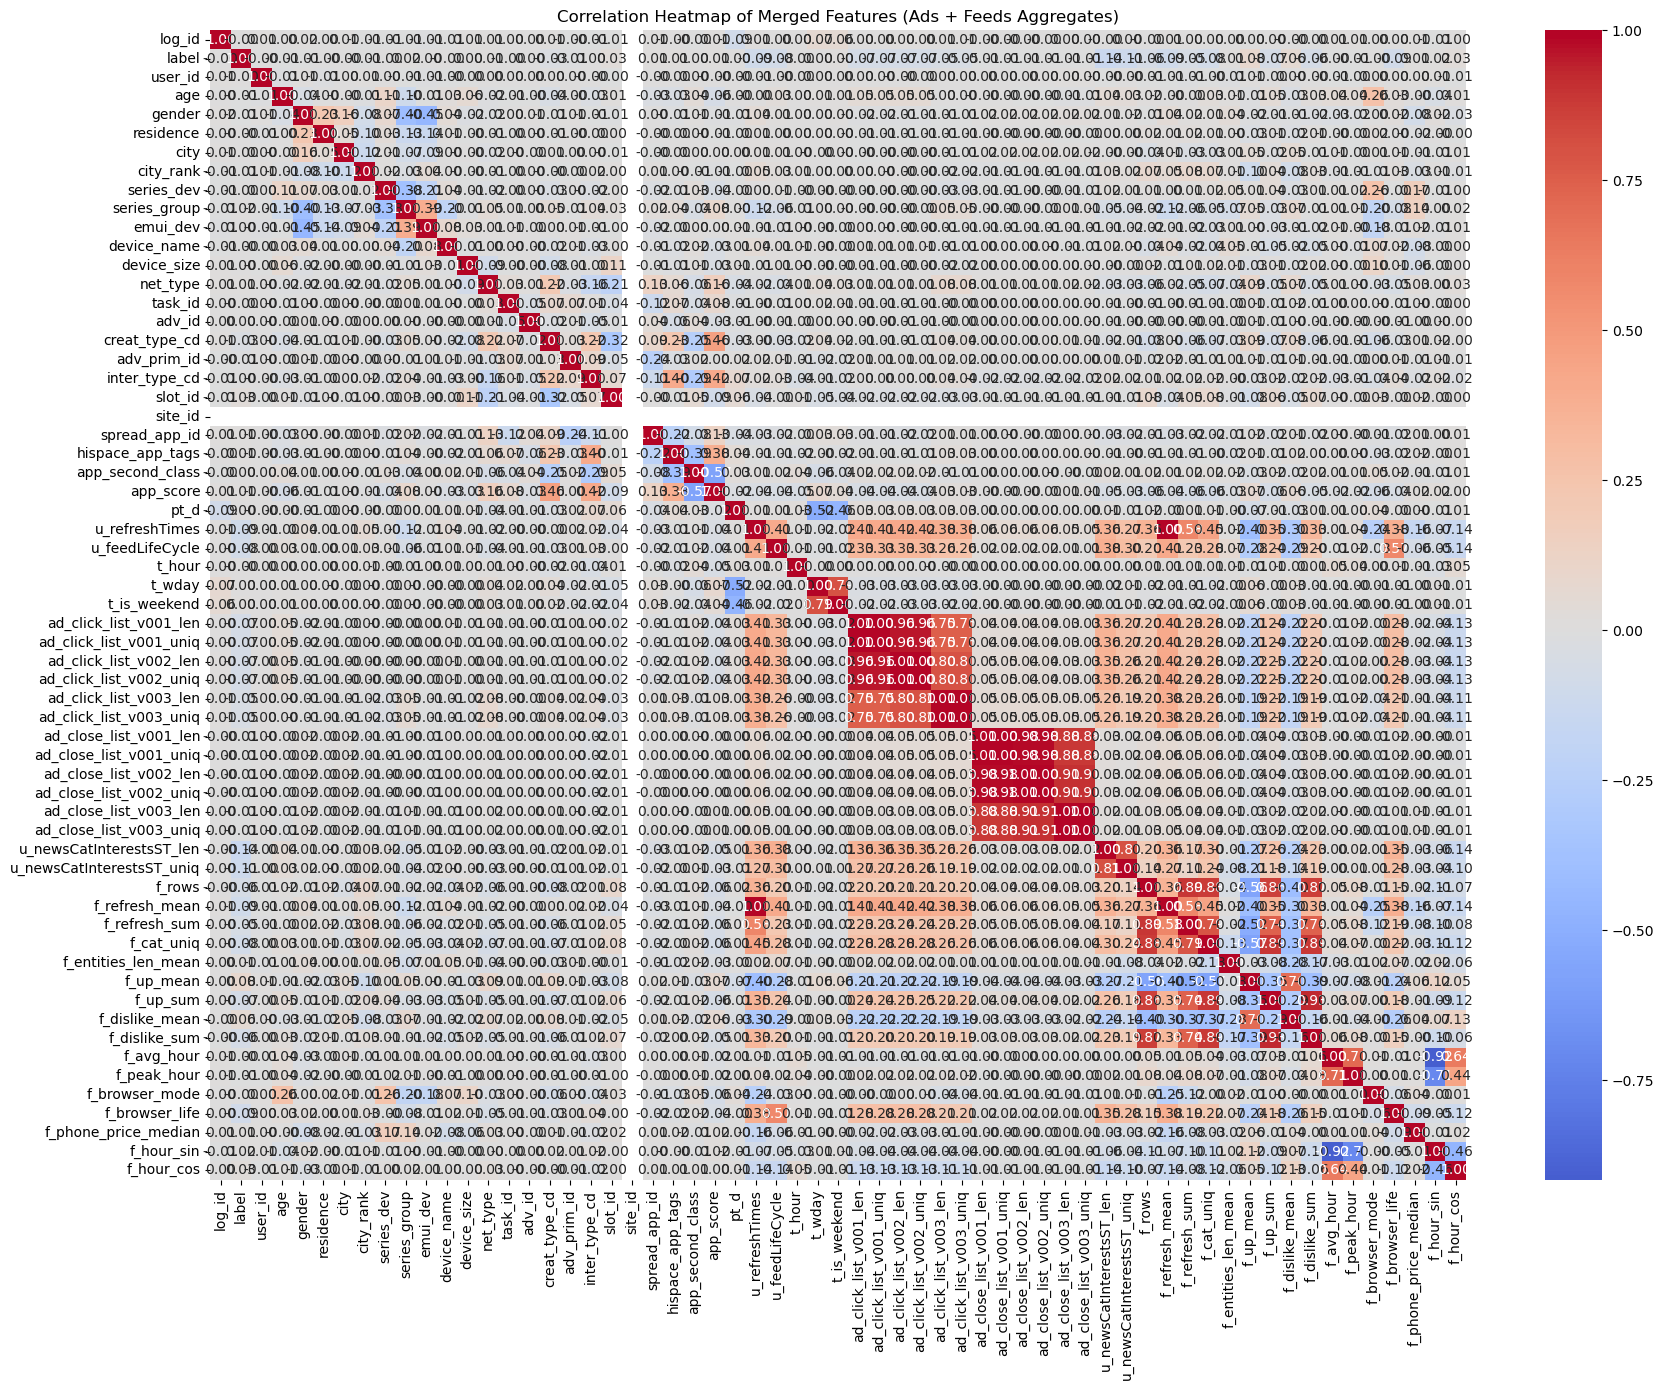

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_cols = train_merged.select_dtypes(include=['number']).columns

# Compute correlation matrix
corr = train_merged[numeric_cols].corr()

# Sort by correlation with label
corr_label_sorted = corr["label"].sort_values(ascending=False)
print("Top correlations with label:\n", corr_label_sorted.head(10))
print("\nLowest correlations with label:\n", corr_label_sorted.tail(10))

# Plot correlation heatmap (with numbers inside)
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr,
    annot=True,          # display numeric values
    fmt=".2f",           # 2 decimal places
    cmap='coolwarm',     # blue-red color gradient
    center=0,
    cbar=True
)
plt.title("Correlation Heatmap of Merged Features (Ads + Feeds Aggregates)")
plt.tight_layout()
plt.show()

## 3.7 Save and Summarize Merged Dataset

### Objective
Finalize the data preparation stage by saving the merged training and testing datasets for modeling.  
This step ensures that the data pipeline is complete and that all features from the ads and feeds domains are aligned for use in machine learning models.

### Key Steps
1. Verified column alignment and absence of major missing values.  
2. Inspected feature correlations and found some clusters of highly correlated pairs (e.g., _len vs _uniq, _sum vs _mean).  
3. Observed meaningful positive correlations between user interaction features (e.g., f_up_mean, f_dislike_mean) and CTR label.  
4. Exported final merged datasets for model training and evaluation.

### Output Files
- `train_merged.parquet`  – Cleaned and merged training dataset with feeds user aggregates  
- `test_merged.parquet`   – Corresponding test dataset aligned for inference  
Both datasets are ready for feature selection and model training in Notebook 4.

In [62]:
# === Step 3.7 Save the final merged datasets ===
import os

output_dir = "outputs_merged"
os.makedirs(output_dir, exist_ok=True)

train_output_path = os.path.join(output_dir, "train_merged.parquet")
test_output_path = os.path.join(output_dir, "test_merged.parquet")

train_merged.to_parquet(train_output_path, index=False)
test_merged.to_parquet(test_output_path, index=False)

print("Final merged datasets saved successfully!")
print(f"Train shape: {train_merged.shape}")
print(f"Test shape:  {test_merged.shape}")
print(f"Saved to folder: {os.path.abspath(output_dir)}")

Final merged datasets saved successfully!
Train shape: (7675517, 68)
Test shape:  (976058, 67)
Saved to folder: /Users/jackiewei/outputs_merged
